## Простое обучение

### Подгружаем нужные библиотеки

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import subprocess

### Качаем данные

In [2]:
def download_and_extract_dataset(url, target_path):
    subprocess.run(['wget', url])
    subprocess.run(['tar', 'xfz', 'petfaces.tar.gz'])
    subprocess.run(['del', 'petfaces.tar.gz'], shell = True)
    print(f"Dataset extracted to {target_path}")

#URL и путь для датасета
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
target_path = 'petfaces'
download_and_extract_dataset(url, target_path)

Dataset extracted to petfaces


### Предобработка данных

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Загрузка и разделение данных
def load_data(path):
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)
    target = [y for _, y in dataset.samples]
    train_idx, test_idx = train_test_split(np.arange(len(target)), test_size=0.2, stratify=target)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)

    return train_dataset, test_dataset

train_dataset, test_dataset = load_data(target_path)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Обучение модели

In [9]:
class PetNet(nn.Module):
    def __init__(self):
        super(PetNet, self).__init__()
        backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.classifier = nn.Linear(backbone.fc.in_features, 36)
        self.binary_classifier = nn.Linear(backbone.fc.in_features, 2)  #Бинарный классификатор для кошек и собак

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  #Преобразуем для линейного классификатора
        breed = self.classifier(x)
        binary = self.binary_classifier(x)
        return breed, binary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetNet().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\imedz/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
#Тренировка модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            breed_outputs, binary_outputs = model(images)
            loss_breed = criterion(breed_outputs, labels)
            loss_binary = criterion(binary_outputs, labels % 2)  #Кошки против собак
            loss = loss_breed + loss_binary
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

#Запуск тренировки
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Loss: 0.11912911385297775
Epoch 2, Loss: 0.15831762552261353
Epoch 3, Loss: 0.5603467226028442
Epoch 4, Loss: 1.4567670822143555
Epoch 5, Loss: 0.7238452434539795
Epoch 6, Loss: 0.7326284050941467
Epoch 7, Loss: 0.23765037953853607
Epoch 8, Loss: 0.17922812700271606
Epoch 9, Loss: 0.20423536002635956
Epoch 10, Loss: 0.36322325468063354


### Оценка модели

In [18]:
class_names = {
    0: 'cat_Abyssinian', 1: 'cat_Bengal', 2: 'cat_Birman', 3: 'cat_Bombay', 4: 'cat_British',
    5: 'cat_Egyptian', 6: 'cat_Maine', 7: 'cat_Persian', 8: 'cat_Ragdoll', 9: 'cat_Russian',
    10: 'cat_Siamese', 11: 'cat_Sphynx', 12: 'dog_american', 13: 'dog_basset', 14: 'dog_beagle',
    15: 'dog_boxer', 16: 'dog_chihuahua', 17: 'dog_english', 18: 'dog_german', 19: 'dog_great',
    20: 'dog_havanese', 21: 'dog_japanese', 22: 'dog_keeshond', 23: 'dog_leonberger',
    24: 'dog_miniature', 25: 'dog_newfoundland', 26: 'dog_pomeranian', 27: 'dog_pug',
    28: 'dog_saint', 29: 'dog_samoyed', 30: 'dog_scottish', 31: 'dog_shiba', 32: 'dog_staffordshire',
    33: 'dog_wheaten', 34: 'dog_yorkshire'
}

binary_names = {0: 'Cat', 1: 'Dog'}

Breed Classification Accuracy:  0.8320373250388803
Binary Classification Accuracy:  0.895800933125972


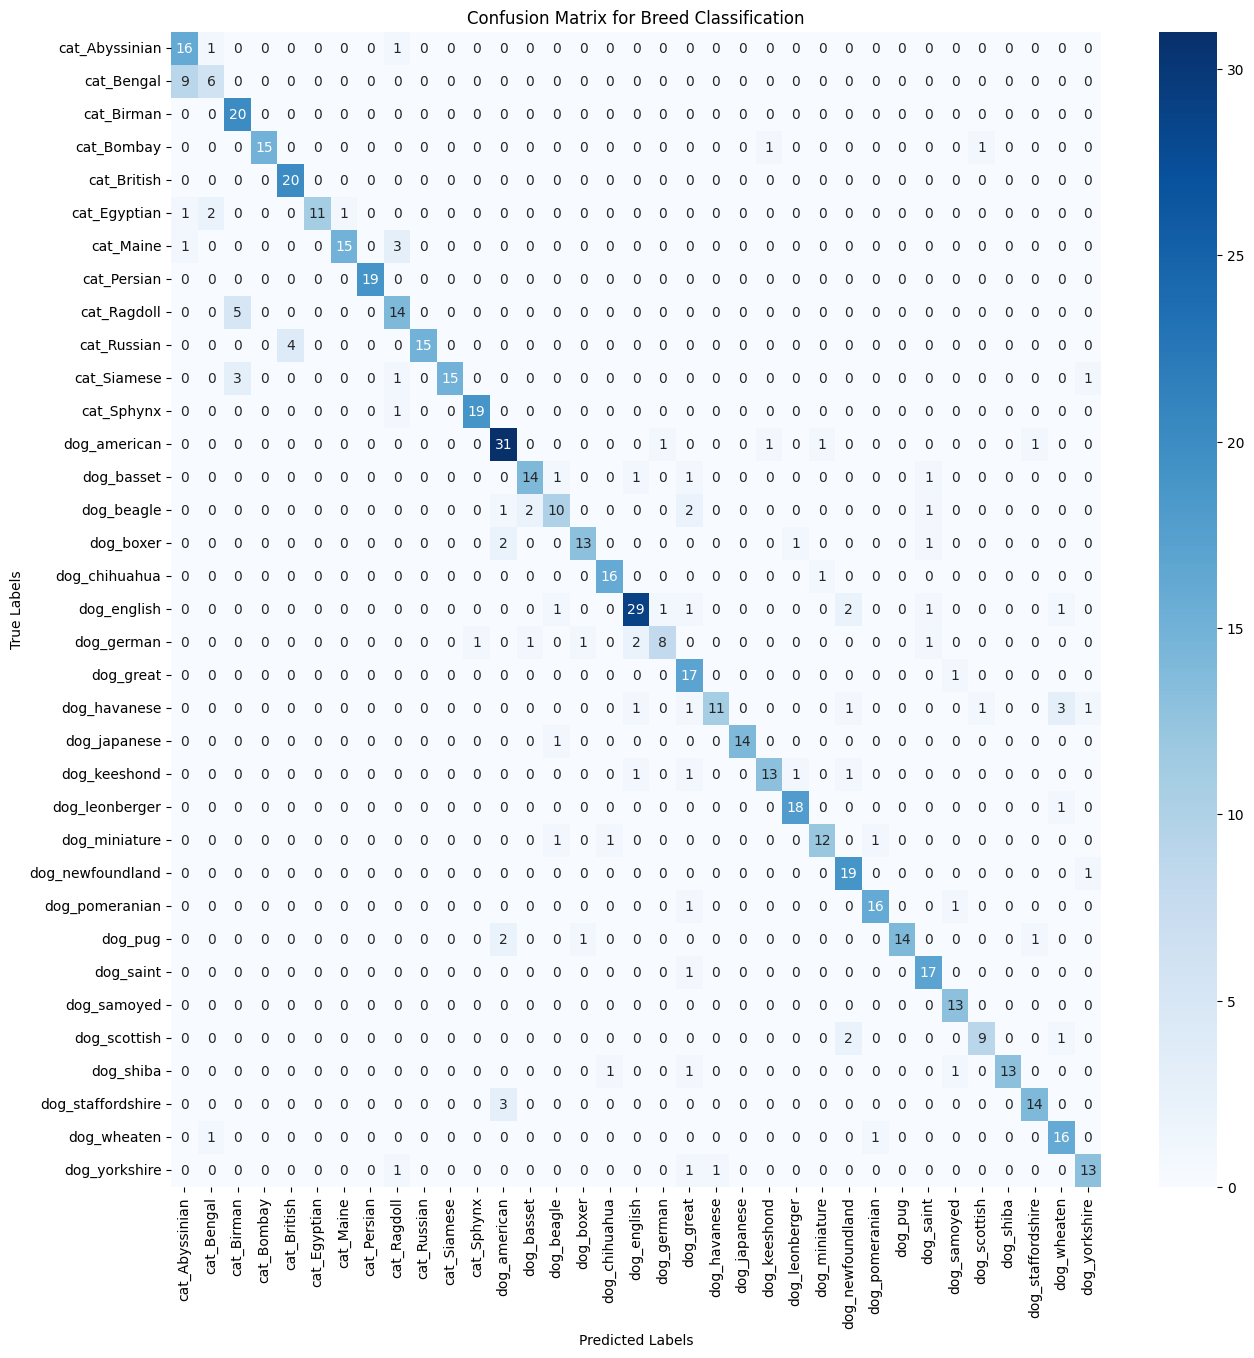

In [21]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds_breed = []
    all_preds_binary = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            breed_outputs, binary_outputs = model(images)
            _, breed_preds = torch.max(breed_outputs, 1)
            _, binary_preds = torch.max(binary_outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds_breed.extend(breed_preds.cpu().numpy())
            all_preds_binary.extend(binary_preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_breed = np.array(all_preds_breed)
    all_preds_binary = np.array(all_preds_binary)

    breed_accuracy = accuracy_score(all_labels, all_preds_breed)
    binary_accuracy = accuracy_score(all_labels % 2, all_preds_binary)

    breed_conf_matrix = confusion_matrix(all_labels, all_preds_breed)

    print("Breed Classification Accuracy: ", breed_accuracy)
    print("Binary Classification Accuracy: ", binary_accuracy)

    class_names_list = list(class_names.values())

    plt.figure(figsize=(15, 15))
    sns.heatmap(breed_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title('Confusion Matrix for Breed Classification')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

evaluate_model(model, test_loader, device)

In [19]:
def calculate_topk_accuracy(model, loader, k=3):
    model.eval()
    correct_topk = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)[0]
            _, pred = output.topk(k, 1, True, True)
            correct_topk += pred.eq(target.view(-1, 1).expand_as(pred)).sum().item()
    topk_acc = correct_topk / len(loader.dataset)
    return topk_acc

top3_accuracy = calculate_topk_accuracy(model, test_loader, k=3)
print(f'Top-3 Accuracy: {top3_accuracy * 100:.2f}%')

Top-3 Accuracy: 97.20%


### Показ результата

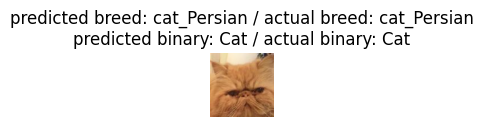

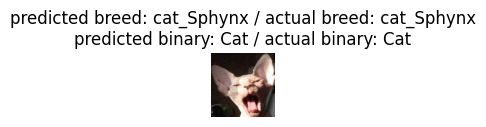

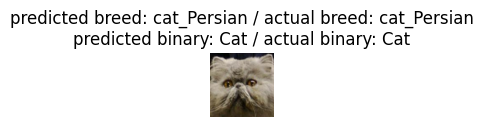

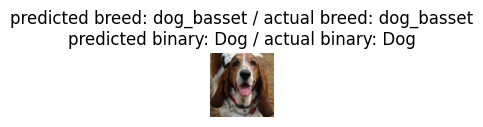

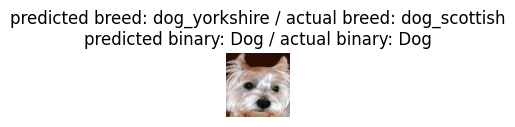

In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=1):
    was_training = model.training
    model.eval()
    images_so_far = 0

    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    indices = indices[:num_images]

    with torch.no_grad():
        for i in indices:
            inputs, labels = test_dataset[i]
            inputs = inputs.unsqueeze(0).to(device)
            labels = torch.tensor([labels]).to(device)

            breed_outputs, binary_outputs = model(inputs)
            _, breed_preds = torch.max(breed_outputs, 1)
            _, binary_preds = torch.max(binary_outputs, 1)

            images_so_far += 1
            ax = plt.subplot(num_images, 1, images_so_far)
            ax.axis('off')
            predicted_breed_name = class_names[breed_preds[0].item()]
            actual_breed_name = class_names[labels[0].item()]
            predicted_binary_name = binary_names[1 if breed_preds[0].item() >= 12 else 0]
            actual_binary_name = binary_names[1 if labels[0].item() >= 12 else 0]

            ax.set_title(f'predicted breed: {predicted_breed_name} / actual breed: {actual_breed_name}\n'
                         f'predicted binary: {predicted_binary_name} / actual binary: {actual_binary_name}')
            imshow(inputs.cpu().squeeze(0))

    model.train(mode=was_training)

visualize_model(model, num_images=5)